In [1]:
import spkit as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import mne
from copy import deepcopy
from mne.preprocessing import compute_proj_ecg
from mne_connectivity import envelope_correlation
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import random
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
import autoreject
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from autoreject import Ransac
from mne.preprocessing import annotate_amplitude


In [2]:
#mne.set_config("MNE_USE_CUDA", True)
#print(mne.get_config("MNE_USE_CUDA"))
print(mne.get_config("MNE_USE_CUDA"))

None


In [3]:
data = np.array(pd.read_csv(r"K:\Clean Data\IGE\shirband\samples.csv", skiprows=2))
data = np.delete(data, [0, 1, -1, -3, -4], axis=1)

In [4]:
#ch_name = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'T2', 'T1', 'ECG']
channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'ECG']
#ch_name = ['F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'T2', 'T1']
np.shape(channel_names)

(22,)

In [5]:
np.shape(data)

(1815746, 22)

In [6]:
X = deepcopy(data)
X = deepcopy(X[1000:-1000])

In [7]:
sfreq = 300
info = mne.create_info(channel_names, sfreq, ch_types=['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'ecg'])
raw = mne.io.RawArray(X.T, info)
raw.set_montage('standard_1020')

Creating RawArray with float64 data, n_channels=22, n_times=1813746
    Range : 0 ... 1813745 =      0.000 ...  6045.817 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,24 points
Good channels,"21 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,ECG
Sampling frequency,300.00 Hz
Highpass,0.00 Hz
Lowpass,150.00 Hz


Using matplotlib as 2D backend.


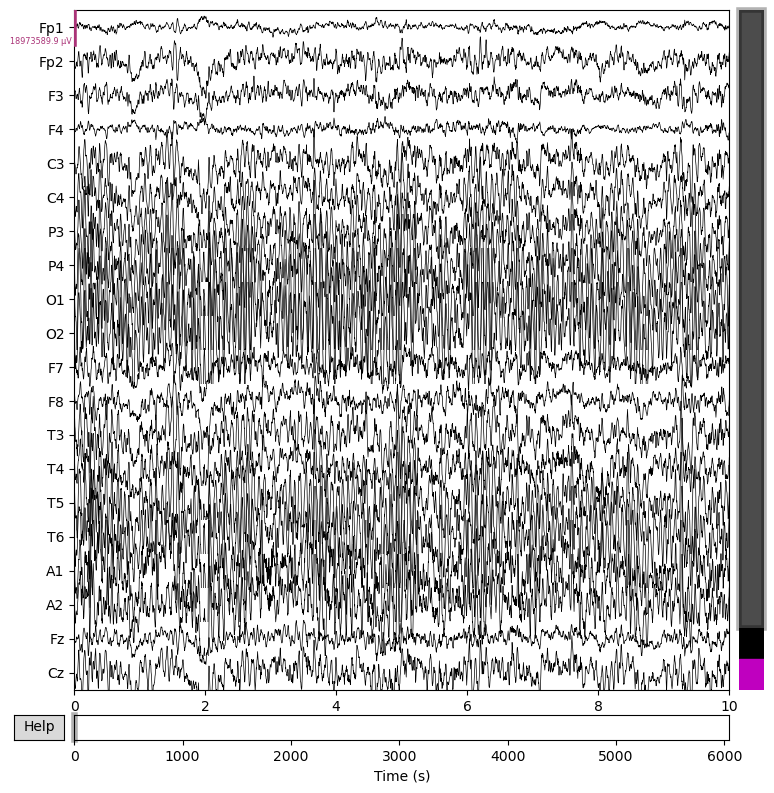

In [8]:
raw.plot(scalings='auto');

In [9]:
ica = ICA(n_components=21, max_iter="auto", random_state=97)
ica.fit(raw)

explained_var_ratio = ica.get_explained_variance_ratio(raw)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

raw.load_data()
#ica.plot_sources(raw, show_scrollbars=False);

Fitting ICA to data using 21 channels (please be patient, this may take a while)


C:\Users\Ozzy\AppData\Local\Temp\ipykernel_10172\3021648357.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.


Selecting by number: 21 components
Fitting ICA took 64.5s.
Fraction of eeg variance explained by all components: 1.0


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,24 points
Good channels,"21 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,ECG
Sampling frequency,300.00 Hz
Highpass,0.00 Hz
Lowpass,150.00 Hz


Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 3000 samples (10.000 s)

Number of ECG events detected : 7726 (average pulse 76 / min.)
Not setting metadata
7726 matching events found
No baseline correction applied
Using data from preloaded Raw for 7726 events and 181 original time points ...
0 bad epochs dropped
Found 2 ECG component(s)


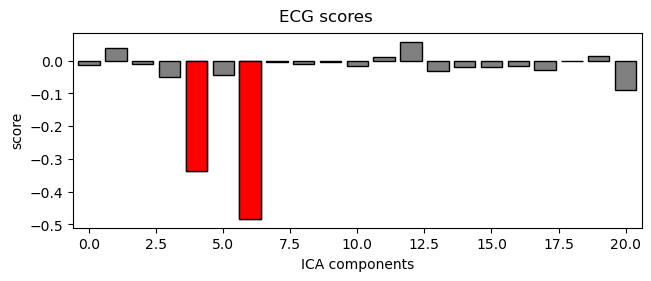

In [10]:
n_max_ecg = 15  
ecg_epochs = create_ecg_epochs(raw, tmin=-.3, tmax=.3)
#ecg_epochs.decimate(5).apply_baseline((None, None))
ecg_inds, scores_ecg = ica.find_bads_ecg(ecg_epochs, threshold='auto', method='correlation')
print('Found %d ECG component(s)' % (len(ecg_inds),))
ica.exclude += ecg_inds[:n_max_ecg]
ica.plot_scores(scores_ecg, exclude=ecg_inds, title='ECG scores');

In [11]:
print(ica.exclude)
ica.apply(raw, exclude=ica.exclude)

[6, 4]
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 2 ICA components
    Projecting back using 21 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,24 points
Good channels,"21 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,ECG
Sampling frequency,300.00 Hz
Highpass,0.00 Hz
Lowpass,150.00 Hz


In [12]:
bad_segments = annotate_amplitude(raw, peak=5, flat=0.2, min_duration=0.1)
raw.set_annotations(bad_segments[0])
bad_segments[0]

Finding segments below or above PTP threshold.


<Annotations | 4 segments: BAD_flat (4)>

In [13]:
epochs = mne.make_fixed_length_epochs(raw, duration=10, preload=True, overlap= 1)

Not setting metadata
671 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 671 events and 3000 original time points ...


2 bad epochs dropped


In [14]:
ar = AutoReject()
new_epochs = ar.fit_transform(epochs)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/669 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/669 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/669 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/669 [00:00<?,       ?it/s]

c:\Users\Ozzy\anaconda3\lib\site-packages\mne\bem.py:1134: RuntimeWarning: Mean of empty slice.
c:\Users\Ozzy\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
c:\Users\Ozzy\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
c:\Users\Ozzy\anaconda3\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=20


  0%|          | Repairing epochs : 0/669 [00:00<?,       ?it/s]

Dropped 10 epochs: 164, 281, 282, 451, 633, 635, 636, 638, 639, 641


In [15]:
new_epochs

Number of events,659
Events,1: 659
Time range,0.000 – 9.997 s
Baseline,off


In [16]:
epochs.save("saved-epochs-test.fif", overwrite=True)

C:\Users\Ozzy\AppData\Local\Temp\ipykernel_10172\1398312199.py:1: RuntimeWarning: This filename (saved-epochs-test.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz


In [18]:
epochs_from_file = mne.read_epochs("saved-epochs-test.fif", preload=False)

Reading k:\Code\EEG\preprocessing\saved-epochs-test.fif ...
    Found the data of interest:
        t =       0.00 ...    9996.67 ms
        0 CTF compensation matrices available
Not setting metadata
669 matching events found
No baseline correction applied
0 projection items activated


C:\Users\Ozzy\AppData\Local\Temp\ipykernel_10172\1956541750.py:1: RuntimeWarning: This filename (saved-epochs-test.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
